In [63]:
import pandas as pd
import numpy as np
from itertools import chain
import datetime

proj_path = '/content/drive/My Drive/Colab Notebooks/NERUsingBiLSTM/data'
emb_path = '/content/drive/My Drive/Colab Notebooks/Embeddings'

### Data Import

In [4]:
data = pd.read_csv(f'{proj_path}/ner_dataset.csv', encoding='unicode_escape')
data.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


##### "Sentence" Analysis

In [5]:
data['Sentence #'] = data['Sentence #'].fillna(method='ffill', axis=0)
sentence_grp = data.groupby('Sentence #')['Word'].count()

In [6]:
n_sentences = data['Sentence #'].nunique() - 1 # -1 for NaN
print('Shape: ', data.shape)
print('Total number of Sentences: ', n_sentences)
print('#words analysis:\n', sentence_grp.describe())

Shape:  (1048575, 4)
Total number of Sentences:  47958
#words analysis:
 count    47959.000000
mean        21.863988
std          7.963680
min          1.000000
25%         16.000000
50%         21.000000
75%         27.000000
max        104.000000
Name: Word, dtype: float64


"Tag" Analysis

In [7]:
n_tags = data['Tag'].nunique()
print('Unique #Tags: ', n_tags)
print('\n----Tags----')
print(pd.Series(data['Tag'].unique()))

Unique #Tags:  17

----Tags----
0         O
1     B-geo
2     B-gpe
3     B-per
4     I-geo
5     B-org
6     I-org
7     B-tim
8     B-art
9     I-art
10    I-per
11    I-gpe
12    I-tim
13    B-nat
14    B-eve
15    I-eve
16    I-nat
dtype: object


### Extract Mappings Req. For Neural Network

In [42]:
def glove_embeddings(glove_file):
  with open(f'{glove_file}/glove.6B.50d.txt', 'r') as f:
    j = 1
    token2vec = {}
    token2idx = {}
    idx2token = {}
    matrix = []
    for line in f:
      line = line.split()
      token = line[0]
      vec = line[1:]
      # Creating word to vector mapping dictionary
      token2vec[token] = vec

      # Creating word to index and index to word mapping
      token2idx[token] = j
      idx2token[j] = token

      # Creating an embedding matrix 
      matrix.append(vec)
      j+=1

    # Handling Missing word's representation suggested by Jeffery Pennington(GloVe Author)
    emb_matrix = np.zeros((len(matrix)+1, len(matrix[0])))
    emb_matrix[1:] = matrix
    emb_matrix[0] = np.mean(emb_matrix, axis=0)    

  return token2vec, token2idx, idx2token, emb_matrix



def get_dict_map(data, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(data['Word']))
    else:
        vocab = list(set(data['Tag']))
    
    idx2tok = {(idx+1):tok for idx, tok in enumerate(vocab)}
    tok2idx = {tok:(idx+1) for idx, tok in enumerate(vocab)}
    
    return tok2idx, idx2tok

token2vec, token2idx, idx2token, emb_matrix = glove_embeddings(emb_path)
# token2idx, idx2token = get_dict_map(data, 'token')
tag2idx, idx2tag = get_dict_map(data, 'tag')
data['Word_idx'] = data['Word'].apply(lambda x: token2idx.get(x.lower(),0))
data['Tag_idx'] = data['Tag'].map(tag2idx)
data.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,Thousands,NNS,O,870,16
1,Sentence: 1,of,IN,O,4,16
2,Sentence: 1,demonstrators,NNS,O,4469,16
3,Sentence: 1,have,VBP,O,34,16
4,Sentence: 1,marched,VBN,O,6427,16


### Grouping words into sequential data

In [45]:
#Groupby and collect columns
data_group = data.groupby(
['Sentence #'],as_index=False).agg(lambda x: list(x))

# Visualise data
data_group.head()

,Sentence #,Word,POS,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[NNS, IN, NNS, VBP, VBN, IN, NNP, TO, VB, DT, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[870, 4, 4469, 34, 6427, 132, 517, 5, 1560, 1,...","[16, 16, 16, 16, 16, 16, 10, 16, 16, 16, 16, 1..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[JJ, NNS, VBP, PRP, VBP, TO, VB, NN, TO, JJ, J...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[1862, 149, 204, 40, 1544, 5, 170, 1123, 5, 57...","[5, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[NN, NNS, NNP, VBD, JJ, NNS, IN, DT, NNP, JJ, ...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[3135, 18436, 278, 13028, 2786, 23037, 7, 1, 5...","[16, 16, 8, 16, 16, 16, 16, 16, 10, 16, 16, 16..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[PRP, VBD, IN, DT, NN, JJ, NN, IN, NN, NNS, .]","[O, O, O, O, O, O, O, O, O, O, O]","[40, 219, 50, 8, 6188, 44397, 6440, 18, 5424, ...","[16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[NNP, NN, NN, NNP, NNP, VBD, NNP, ,, NNP, ,, J...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[731, 1826, 5222, 4188, 29459, 17, 241, 2, 100...","[10, 16, 16, 12, 1, 16, 8, 16, 10, 16, 5, 16, ..."


#### Split the dataset into train, test after padding

In [46]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


In [47]:
sequence_maxlen = max(data_group['Word_idx'].map(len))

In [48]:
def padding_seq(feature, seq_maxlen, method=None, onehot_maxlen=None):
  
  padded_feature = pad_sequences(feature, maxlen = seq_maxlen, padding='post')

  if method == 'onehot':
    # +1 is added for '0' value 
    padded_feature = [to_categorical(i, num_classes=onehot_maxlen+1) for i in padded_feature]
  
  return padded_feature

def train_test_val_split(pad_tokens, pad_tags):

    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, random_state=40)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_, tags_, test_size=0.25, random_state=40)
    
    print(f"""Train Tokens Length: {len(train_tokens)}
Train Tags Lenght: {len(train_tags)}
Test Tokens Lenght: {len(test_tokens)}
Test Tags Lenght: {len(test_tags)}
val Tokens Lenght: {len(val_tokens)}
val Tags Lenght: {len(val_tags)}""")
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [49]:
pad_tokens = padding_seq(data_group['Word_idx'], sequence_maxlen)
pad_tags = padding_seq(data_group['Tag_idx'], sequence_maxlen, method='onehot', onehot_maxlen=n_tags)
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = train_test_val_split(pad_tokens, pad_tags)

Train Tokens Length: 32372
Train Tags Lenght: 32372
Test Tokens Lenght: 4796
Test Tags Lenght: 4796
val Tokens Lenght: 10791
val Tags Lenght: 10791


#### Building the model architecture

In [50]:
import tensorflow as tf
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, \
TimeDistributed, Dropout, Bidirectional
from tensorflow.keras.utils import plot_model
import keras.backend as K

# Setting random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [53]:
# Variables for Neural Networks:
input_dim = len(emb_matrix)
output_dim = len(emb_matrix[0])
input_length = max([len(s) for s in data_group['Word_idx'].tolist()])
n_tags = len(tag2idx)+1
print('input_dim: ', input_dim, '\noutput_dim: ', output_dim, '\ninput_length: ', input_length, '\nn_tags: ', n_tags)

input_dim:  400001 
output_dim:  50 
input_length:  104 
n_tags:  18


### IMPORTANT NOTE:
* I've removed 'recurrent dropout' from both LSTM layers as cuDNN doesn't support it.

Feel free to try it.

In [52]:
# F1 Metric Function
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [57]:
def get_bilstm_model(metrics = 'accuracy'):

  # Input
  sequence_input = Input(shape=((input_length,)), dtype='int32')

  #Add Embedding Layers
  emb_layer = Embedding(input_dim=input_dim, output_dim=output_dim, weights=[emb_matrix], trainable=False)(sequence_input)

  # Add bidirectional LSTM
  bidir_lstm = Bidirectional(LSTM(units=output_dim, dropout=0.5, return_sequences=True))(emb_layer)

  # Add LSTM
  lstm = LSTM(units=256, dropout=0.2, return_sequences=True)(bidir_lstm)

  # Add timeDistributed Layer
  output = TimeDistributed(Dense(n_tags, activation='softmax'))(lstm)

  # Model Creation
  model = Model(inputs=[sequence_input], outputs=[output])

  # Complie Model
  if metrics == 'accuracy':
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  elif metrics == 'F1':
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[get_f1])

  model.summary()
  
  return model

In [64]:
# # Tensorboard Settings (Enable them incase you want to analyze the results in Tensorboard)
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# Do add callback function inside model.fit like:-
#    callbacks=[tensorboard_callback]

def train_model(X, y, model, epoches, val=False, val_X=None, val_y=None):

    if val:
      hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=epoches, validation_split=0.2)
    else:
      hist = model.fit(X, y, batch_size=1000, verbose=1, epochs=epoches, validation_data=(val_X, val_y))
  
    return hist

In [66]:
model_bilstm = get_bilstm_model()
history = train_model(train_tokens, np.array(train_tags), model_bilstm, 40, True, val_tokens, np.array(val_tags))

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 104)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 104, 50)           20000050  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 104, 100)          40400     
_________________________________________________________________
lstm_7 (LSTM)                (None, 104, 256)          365568    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 104, 18)           4626      
Total params: 20,410,644
Trainable params: 410,594
Non-trainable params: 20,000,050
_________________________________________________________________
Epoch 1/40
26/26 [==============================] - 6s 219ms/step - loss: 0.6734 - accuracy: 0.9058 - val_l

In [69]:
# # Loading Tensorboard
# %load_ext tensorboard
# %tensorboard --logdir logs/fit

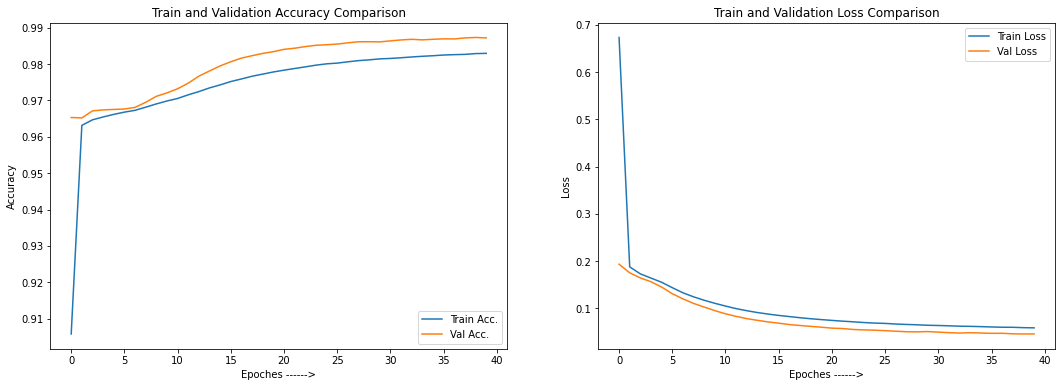

In [70]:
import matplotlib.pyplot as plt

def learning_curve(hist_obj, title):
  hist = pd.DataFrame(hist_obj.history)

  hist1 = hist[['accuracy', 'val_accuracy']]
  hist2 = hist[['loss', 'val_loss']]
  plt.figure(figsize=(18, 6))
  plt.subplot(1, 2, 1)
  plt.plot(hist1)
  plt.xlabel('Epoches ------>')
  plt.ylabel('Accuracy')
  plt.legend(['Train Acc.', 'Val Acc.'], loc='lower right')
  plt.title('Train and Validation Accuracy Comparison')
  plt.subplot(1, 2, 2)
  plt.plot(hist2)
  plt.xlabel('Epoches ------>')
  plt.ylabel('Loss')
  plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
  plt.title('Train and Validation Loss Comparison')
  plt.show()

learning_curve(history, 'Learning Curves')

#### Accuracy on Test Data

In [71]:
loss, accuracy = model_bilstm.evaluate(test_tokens, np.array(test_tags), verbose=0)

print('Loss: {0:.2%} and Accuracy: {1:.2%} for Test Dataset.'.format(loss, accuracy))

Loss: 4.52% and Accuracy: 98.73% for Test Dataset.


#### Checking results on real data:

In [88]:
def NER(text):
  t = text.lower().split()
  maxlen = len(set(data['Word']))
  t = [token2idx.get(i,0) for i in t]

  s = pad_sequences([t], maxlen = 104, padding='post')
  r = model_bilstm.predict(s)

  result = [idx2tag.get(i,'O') for i in np.argmax(r[0], axis=1)[:len(t)]]
  conf = ['{:.2f}'.format(i) for i in np.max(r[0], axis=1)[:len(t)]]
  return result, conf

In [94]:
print("Steve went to Paris for 8 days")
result, conf = NER("Steve went to Paris for 8 days")
print(result,'\n',conf)

print("\nJohn lives in New York")
result, conf = NER("John lives in New York")
print(result,'\n',conf)

Steve went to Paris for 8 days
['B-per', 'O', 'O', 'B-geo', 'O', 'B-tim', 'O'] 
 ['0.83', '0.98', '1.00', '0.85', '0.95', '0.61', '0.93']

John lives in New York
['B-per', 'O', 'O', 'B-geo', 'I-geo'] 
 ['0.94', '0.79', '0.99', '0.83', '0.73']


### Future Explorations

* Try fixing data imbalance problem.
* Try "fused batch norm" instead of batch norm for fast processing.
* Try FastText by Facebook to handle semantic representation of out of vocabulary words.